# LSTM Model for predicting trend

In [1]:
#imports
import numpy as np
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dropout
import sklearn
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.layers import Dense
import keras.utils
from keras.layers import LSTM
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
import seed
import os
tf.get_logger().setLevel('ERROR')

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [3]:
#function to calculate rsi
def rsi(ohlc, period: int = 14) -> pd.Series:
    """See source https://github.com/peerchemist/finta
    and fix https://www.tradingview.com/wiki/Talk:Relative_Strength_Index_(RSI)
    Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
    RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
    Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
    RSI can also be used to identify the general trend."""

    delta = ohlc["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    _gain = up.ewm(com=(period - 1), min_periods=period).mean()
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = _gain / _loss
    return 100 - (100 / (1 + RS))

In [8]:
#lag granularity - days or hours
lag_granularity = "days"
#lag value
lag = 1
# type of analyser - TextBlob or vader
analyser = "vader"
# analyser = "TextBlob"
#dataset grouped type - day or hour
dataset_grouped_by = "day"
cleaned = True

In [9]:
#read dataset
folder = "./../datasets/tweets_prices_volumes_sentiment/"+analyser+"/"+dataset_grouped_by+"_datasets/"

if(cleaned):
    folder = folder+"cleaned"
filename = folder+"/final_data_lag_"+lag_granularity+"_"+str(lag)+".csv" if (lag > 0) else folder+"/final_data_no_lag.csv"
df = pd.read_csv(filename)

In [10]:
#group by datetime
df = df.groupby('DateTime').agg(lambda x: x.mean())

In [11]:
#get change label
df["Change"] = (df["Close"] > df["Close"].shift(1)).astype(int)

add_RSI = False
add_longMAvg = False
add_shortMAvg = False

if(add_RSI):
    #calcualte RSI
    RSI = 14
    df['RSI'] = rsi(df, RSI)
    df = df.iloc[RSI:]

#calculate moving averages
if(add_shortMAvg):
    short_window = 9
    df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()
    
if(add_longMAvg):
    long_window = 21
    df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()
    
if(add_longMAvg):
    df = df.iloc[long_window:]
elif(add_RSI):
    df = df.iloc[RSI:]
elif(add_shortMAvg):
    df = df.iloc[short_window:]

In [12]:
#keep only wanted columns
features = ['Change', 'subjectivity', 'polarity','Tweet_vol','Volume_(BTC)'] if analyser == "Textblob" else ['Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']

if(add_RSI):
    features.append("RSI")
    
if(add_longMAvg):
    features.append("long_mavg")
    
if(add_shortMAvg):
    features.append("short_mavg")

df = df[features]

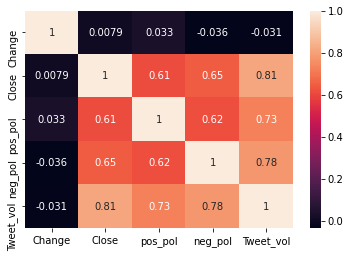

In [13]:
#plot correlation matrix
sn.heatmap(df.corr(), annot=True)
plt.show()

In [14]:
#creating copy so that data is not loaded once again
df_copy = df.copy()

In [15]:
print(features)

['Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']


In [20]:
#number of previous records to consider for every example
n_lag = 14
#number of features
n_features = len(features)
#calculate total_features
total_features = n_lag*n_features

if(total_features == 0):
    total_features = n_features

In [21]:
#divide df into train and test
train_ratio = 0.85
data_len = len(df_copy)
train_size = int(data_len*train_ratio)

train = df_copy.iloc[:train_size]
test = df_copy.iloc[train_size:]

In [22]:
#prepare labels
train_y = train["Change"][n_lag:].values
test_y = test["Change"][n_lag:].values

train_y = train_y.reshape(len(train_y), 1)
test_y = test_y.reshape(len(test_y), 1)

In [23]:
#normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
train = xscaler.fit_transform(train)
test = xscaler.transform(test)

In [24]:
#add lagged data to records
train_reframed = series_to_supervised(train, n_lag, 1)
train_reframed =  train_reframed.reset_index()
train_reframed = train_reframed.drop(['index'], axis=1)

test_reframed = series_to_supervised(test, n_lag, 1)
test_reframed =  test_reframed.reset_index()
test_reframed = test_reframed.drop(['index'], axis=1)

In [25]:
def get_cols_to_rem_label(n_lag, n_features, label_col):
    to_rem = []
    for i in range(1, n_features+1):
        for j in range(0, n_lag+1):
            if(j!=0 or i != label_col):
                if(j == 0):
                    to_rem.append("var"+str(i)+"(t)")
                else:
                    to_rem.append("var"+str(i)+"(t-"+str(j)+")")
    return to_rem
    
def get_cols_to_rem_feat(n_lag, n_features, label_col):
    #uncomment the below line to only remove the last price
    to_rem = ["var1(t)", "var2(t)"]
    return to_rem

In [26]:
train_reframed = train_reframed.drop(get_cols_to_rem_feat(n_lag, n_features, 1), axis=1)
test_reframed = test_reframed.drop(get_cols_to_rem_feat(n_lag, n_features, 1), axis=1)

In [27]:
#tprepare data
train = train_reframed.values
test = test_reframed.values
train_labels = train_y
test_labels = test_y

In [28]:
#remove the last set of values(data of time to be predicted)
train = train[:, :total_features]
test = test[:, :total_features]

In [29]:
#keep only prices array
train_X, train_y = train[:, :total_features], train_y[:, -1]
test_X, test_y = test[:, :total_features], test_y[:, -1]

In [30]:
# reshape input to be 3D [samples, timesteps, features]
if(n_lag > 0):
    train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
else:
    train_X = train_X.reshape((train_X.shape[0], 1, n_features-1))
    test_X = test_X.reshape((test_X.shape[0], 1, n_features-1))

In [31]:
#set labels for training data to categorical
train_y = keras.utils.to_categorical(train_y, 2)

In [32]:
np.random.seed(1)
tf.random.set_seed(1)

# design network
model = Sequential()
neurons = 32
epochs = 1000
dropout = 0.25
batch_size = 5
activ_func = "linear"

model.add(LSTM(neurons, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), activation=activ_func))
model.add(Dropout(dropout))

model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=False, activation=activ_func))
model.add(Dropout(dropout))

model.add(Dense(2, activation="softmax"))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False,validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 32)            4864      
_________________________________________________________________
dropout (Dropout)            (None, 14, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 32)            8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 6

Epoch 70/1000
59/59 - 1s - loss: 0.6488 - accuracy: 0.6339 - val_loss: 1.1130 - val_accuracy: 0.5405
Epoch 71/1000
59/59 - 1s - loss: 0.6561 - accuracy: 0.6169 - val_loss: 0.7770 - val_accuracy: 0.5270
Epoch 72/1000
59/59 - 1s - loss: 0.6382 - accuracy: 0.6237 - val_loss: 0.7660 - val_accuracy: 0.5405
Epoch 73/1000
59/59 - 1s - loss: 0.6402 - accuracy: 0.6102 - val_loss: 0.7786 - val_accuracy: 0.5270
Epoch 74/1000
59/59 - 1s - loss: 0.6308 - accuracy: 0.6373 - val_loss: 0.8007 - val_accuracy: 0.4730
Epoch 75/1000
59/59 - 1s - loss: 0.6261 - accuracy: 0.6644 - val_loss: 0.8689 - val_accuracy: 0.4730
Epoch 76/1000
59/59 - 1s - loss: 0.6388 - accuracy: 0.6441 - val_loss: 0.7892 - val_accuracy: 0.4865
Epoch 77/1000
59/59 - 1s - loss: 0.6285 - accuracy: 0.6780 - val_loss: 0.8103 - val_accuracy: 0.4730
Epoch 78/1000
59/59 - 1s - loss: 0.6124 - accuracy: 0.6542 - val_loss: 0.8531 - val_accuracy: 0.5541
Epoch 79/1000
59/59 - 1s - loss: 0.6615 - accuracy: 0.6102 - val_loss: 0.8910 - val_accurac

Epoch 151/1000
59/59 - 1s - loss: 0.5746 - accuracy: 0.6881 - val_loss: 1.0340 - val_accuracy: 0.4054
Epoch 152/1000
59/59 - 1s - loss: 0.5159 - accuracy: 0.7356 - val_loss: 1.1159 - val_accuracy: 0.4054
Epoch 153/1000
59/59 - 1s - loss: 0.5109 - accuracy: 0.7424 - val_loss: 1.1310 - val_accuracy: 0.4865
Epoch 154/1000
59/59 - 1s - loss: 0.4927 - accuracy: 0.7356 - val_loss: 1.1910 - val_accuracy: 0.4189
Epoch 155/1000
59/59 - 1s - loss: 0.4898 - accuracy: 0.7525 - val_loss: 1.2846 - val_accuracy: 0.5270
Epoch 156/1000
59/59 - 1s - loss: 0.5152 - accuracy: 0.7085 - val_loss: 1.2569 - val_accuracy: 0.4730
Epoch 157/1000
59/59 - 1s - loss: 0.6315 - accuracy: 0.6814 - val_loss: 1.2450 - val_accuracy: 0.3919
Epoch 158/1000
59/59 - 1s - loss: 0.5757 - accuracy: 0.6881 - val_loss: 1.0397 - val_accuracy: 0.4595
Epoch 159/1000
59/59 - 1s - loss: 0.5472 - accuracy: 0.7153 - val_loss: 1.2860 - val_accuracy: 0.3919
Epoch 160/1000
59/59 - 1s - loss: 0.5494 - accuracy: 0.7186 - val_loss: 1.2550 - v

Epoch 232/1000
59/59 - 1s - loss: 0.3167 - accuracy: 0.8712 - val_loss: 5.5675 - val_accuracy: 0.4730
Epoch 233/1000
59/59 - 1s - loss: 0.3234 - accuracy: 0.8508 - val_loss: 6.0519 - val_accuracy: 0.4865
Epoch 234/1000
59/59 - 1s - loss: 0.2770 - accuracy: 0.8576 - val_loss: 6.1658 - val_accuracy: 0.4595
Epoch 235/1000
59/59 - 1s - loss: 0.2921 - accuracy: 0.8644 - val_loss: 8.3064 - val_accuracy: 0.4730
Epoch 236/1000
59/59 - 1s - loss: 0.2751 - accuracy: 0.8949 - val_loss: 7.2361 - val_accuracy: 0.4865
Epoch 237/1000
59/59 - 1s - loss: 0.3538 - accuracy: 0.8271 - val_loss: 6.1010 - val_accuracy: 0.4189
Epoch 238/1000
59/59 - 1s - loss: 0.3748 - accuracy: 0.8237 - val_loss: 5.2840 - val_accuracy: 0.4324
Epoch 239/1000
59/59 - 1s - loss: 0.4331 - accuracy: 0.7966 - val_loss: 5.1243 - val_accuracy: 0.4189
Epoch 240/1000
59/59 - 1s - loss: 0.4307 - accuracy: 0.7831 - val_loss: 5.2707 - val_accuracy: 0.4189
Epoch 241/1000
59/59 - 1s - loss: 0.3611 - accuracy: 0.8610 - val_loss: 7.2002 - v

Epoch 313/1000
59/59 - 2s - loss: 0.2758 - accuracy: 0.8746 - val_loss: 4.4213 - val_accuracy: 0.4730
Epoch 314/1000
59/59 - 1s - loss: 0.1697 - accuracy: 0.9322 - val_loss: 4.4775 - val_accuracy: 0.4189
Epoch 315/1000
59/59 - 2s - loss: 0.1879 - accuracy: 0.9322 - val_loss: 4.2532 - val_accuracy: 0.4730
Epoch 316/1000
59/59 - 1s - loss: 0.1684 - accuracy: 0.9288 - val_loss: 4.3310 - val_accuracy: 0.4324
Epoch 317/1000
59/59 - 2s - loss: 0.1346 - accuracy: 0.9390 - val_loss: 4.3161 - val_accuracy: 0.5135
Epoch 318/1000
59/59 - 2s - loss: 0.1687 - accuracy: 0.9288 - val_loss: 4.4216 - val_accuracy: 0.4459
Epoch 319/1000
59/59 - 2s - loss: 0.2018 - accuracy: 0.9186 - val_loss: 3.9402 - val_accuracy: 0.5000
Epoch 320/1000
59/59 - 2s - loss: 0.1594 - accuracy: 0.9492 - val_loss: 3.9106 - val_accuracy: 0.4595
Epoch 321/1000
59/59 - 2s - loss: 0.1756 - accuracy: 0.9288 - val_loss: 5.3492 - val_accuracy: 0.4595
Epoch 322/1000
59/59 - 2s - loss: 0.1954 - accuracy: 0.9153 - val_loss: 4.9339 - v

Epoch 394/1000
59/59 - 2s - loss: 0.1257 - accuracy: 0.9390 - val_loss: 5.2737 - val_accuracy: 0.4054
Epoch 395/1000
59/59 - 2s - loss: 0.2140 - accuracy: 0.9390 - val_loss: 3.3778 - val_accuracy: 0.5000
Epoch 396/1000
59/59 - 1s - loss: 0.1725 - accuracy: 0.9390 - val_loss: 4.2452 - val_accuracy: 0.3784
Epoch 397/1000
59/59 - 2s - loss: 0.1160 - accuracy: 0.9525 - val_loss: 4.5038 - val_accuracy: 0.3919
Epoch 398/1000
59/59 - 1s - loss: 0.0873 - accuracy: 0.9593 - val_loss: 4.4351 - val_accuracy: 0.4324
Epoch 399/1000
59/59 - 2s - loss: 0.0784 - accuracy: 0.9661 - val_loss: 4.2105 - val_accuracy: 0.4730
Epoch 400/1000
59/59 - 1s - loss: 0.0783 - accuracy: 0.9729 - val_loss: 4.9882 - val_accuracy: 0.4189
Epoch 401/1000
59/59 - 2s - loss: 0.1173 - accuracy: 0.9559 - val_loss: 4.9416 - val_accuracy: 0.4459
Epoch 402/1000
59/59 - 1s - loss: 0.1530 - accuracy: 0.9424 - val_loss: 5.4373 - val_accuracy: 0.3649
Epoch 403/1000
59/59 - 2s - loss: 0.1372 - accuracy: 0.9390 - val_loss: 3.9363 - v

Epoch 475/1000
59/59 - 2s - loss: 0.1046 - accuracy: 0.9492 - val_loss: 4.1939 - val_accuracy: 0.4595
Epoch 476/1000
59/59 - 2s - loss: 0.0873 - accuracy: 0.9593 - val_loss: 4.2580 - val_accuracy: 0.4865
Epoch 477/1000
59/59 - 1s - loss: 0.0499 - accuracy: 0.9831 - val_loss: 4.6057 - val_accuracy: 0.5270
Epoch 478/1000
59/59 - 2s - loss: 0.0352 - accuracy: 0.9898 - val_loss: 4.5117 - val_accuracy: 0.5541
Epoch 479/1000
59/59 - 2s - loss: 0.0638 - accuracy: 0.9695 - val_loss: 5.1504 - val_accuracy: 0.4865
Epoch 480/1000
59/59 - 1s - loss: 0.0614 - accuracy: 0.9831 - val_loss: 4.1576 - val_accuracy: 0.5405
Epoch 481/1000
59/59 - 2s - loss: 0.0509 - accuracy: 0.9831 - val_loss: 5.6584 - val_accuracy: 0.5000
Epoch 482/1000
59/59 - 1s - loss: 0.0603 - accuracy: 0.9797 - val_loss: 5.4282 - val_accuracy: 0.4324
Epoch 483/1000
59/59 - 1s - loss: 0.0590 - accuracy: 0.9864 - val_loss: 5.2986 - val_accuracy: 0.4730
Epoch 484/1000
59/59 - 1s - loss: 0.0677 - accuracy: 0.9763 - val_loss: 5.7803 - v

Epoch 556/1000
59/59 - 2s - loss: 0.0510 - accuracy: 0.9864 - val_loss: 3.8409 - val_accuracy: 0.4459
Epoch 557/1000
59/59 - 2s - loss: 0.0387 - accuracy: 0.9864 - val_loss: 4.2010 - val_accuracy: 0.4189
Epoch 558/1000
59/59 - 1s - loss: 0.0428 - accuracy: 0.9932 - val_loss: 4.3706 - val_accuracy: 0.4459
Epoch 559/1000
59/59 - 2s - loss: 0.0233 - accuracy: 1.0000 - val_loss: 4.5695 - val_accuracy: 0.4459
Epoch 560/1000
59/59 - 2s - loss: 0.0380 - accuracy: 0.9932 - val_loss: 5.2051 - val_accuracy: 0.4459
Epoch 561/1000
59/59 - 2s - loss: 0.0352 - accuracy: 0.9932 - val_loss: 5.0527 - val_accuracy: 0.4189
Epoch 562/1000
59/59 - 2s - loss: 0.0320 - accuracy: 0.9898 - val_loss: 5.4005 - val_accuracy: 0.4595
Epoch 563/1000
59/59 - 2s - loss: 0.0400 - accuracy: 0.9831 - val_loss: 4.6359 - val_accuracy: 0.4595
Epoch 564/1000
59/59 - 2s - loss: 0.0465 - accuracy: 0.9864 - val_loss: 4.9956 - val_accuracy: 0.4595
Epoch 565/1000
59/59 - 2s - loss: 0.0469 - accuracy: 0.9864 - val_loss: 4.7982 - v

Epoch 637/1000
59/59 - 2s - loss: 0.0213 - accuracy: 0.9966 - val_loss: 4.3316 - val_accuracy: 0.4459
Epoch 638/1000
59/59 - 2s - loss: 0.0122 - accuracy: 1.0000 - val_loss: 4.3001 - val_accuracy: 0.4595
Epoch 639/1000
59/59 - 2s - loss: 0.0168 - accuracy: 0.9966 - val_loss: 4.4706 - val_accuracy: 0.4730
Epoch 640/1000
59/59 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 4.5616 - val_accuracy: 0.5000
Epoch 641/1000
59/59 - 2s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 4.4111 - val_accuracy: 0.4730
Epoch 642/1000
59/59 - 1s - loss: 0.0099 - accuracy: 1.0000 - val_loss: 4.6618 - val_accuracy: 0.4595
Epoch 643/1000
59/59 - 1s - loss: 0.0242 - accuracy: 0.9966 - val_loss: 5.1603 - val_accuracy: 0.4595
Epoch 644/1000
59/59 - 1s - loss: 0.0314 - accuracy: 0.9864 - val_loss: 4.5922 - val_accuracy: 0.4865
Epoch 645/1000
59/59 - 1s - loss: 0.0496 - accuracy: 0.9864 - val_loss: 4.6606 - val_accuracy: 0.4595
Epoch 646/1000
59/59 - 1s - loss: 0.1586 - accuracy: 0.9458 - val_loss: 6.5450 - v

Epoch 718/1000
59/59 - 1s - loss: 0.0155 - accuracy: 1.0000 - val_loss: 4.2113 - val_accuracy: 0.5135
Epoch 719/1000
59/59 - 2s - loss: 0.0323 - accuracy: 0.9966 - val_loss: 4.0332 - val_accuracy: 0.4865
Epoch 720/1000
59/59 - 2s - loss: 0.1525 - accuracy: 0.9627 - val_loss: 4.0646 - val_accuracy: 0.4595
Epoch 721/1000
59/59 - 1s - loss: 0.0653 - accuracy: 0.9797 - val_loss: 4.8693 - val_accuracy: 0.4730
Epoch 722/1000
59/59 - 1s - loss: 0.0535 - accuracy: 0.9831 - val_loss: 5.1013 - val_accuracy: 0.5135
Epoch 723/1000
59/59 - 1s - loss: 0.0866 - accuracy: 0.9729 - val_loss: 5.2197 - val_accuracy: 0.4324
Epoch 724/1000
59/59 - 1s - loss: 0.1186 - accuracy: 0.9661 - val_loss: 4.7596 - val_accuracy: 0.4054
Epoch 725/1000
59/59 - 1s - loss: 0.0538 - accuracy: 0.9864 - val_loss: 4.2540 - val_accuracy: 0.4595
Epoch 726/1000
59/59 - 2s - loss: 0.0372 - accuracy: 0.9831 - val_loss: 5.2263 - val_accuracy: 0.4324
Epoch 727/1000
59/59 - 1s - loss: 0.0219 - accuracy: 0.9898 - val_loss: 5.5813 - v

Epoch 799/1000
59/59 - 1s - loss: 0.0393 - accuracy: 0.9864 - val_loss: 6.9990 - val_accuracy: 0.5270
Epoch 800/1000
59/59 - 2s - loss: 0.0402 - accuracy: 0.9864 - val_loss: 7.5617 - val_accuracy: 0.4865
Epoch 801/1000
59/59 - 2s - loss: 0.0456 - accuracy: 0.9831 - val_loss: 7.3256 - val_accuracy: 0.4730
Epoch 802/1000
59/59 - 2s - loss: 0.1027 - accuracy: 0.9559 - val_loss: 4.5511 - val_accuracy: 0.4459
Epoch 803/1000
59/59 - 2s - loss: 0.2462 - accuracy: 0.9051 - val_loss: 5.2394 - val_accuracy: 0.4730
Epoch 804/1000
59/59 - 2s - loss: 0.1527 - accuracy: 0.9390 - val_loss: 4.9129 - val_accuracy: 0.4459
Epoch 805/1000
59/59 - 2s - loss: 0.0541 - accuracy: 0.9831 - val_loss: 4.4034 - val_accuracy: 0.4459
Epoch 806/1000
59/59 - 2s - loss: 0.0360 - accuracy: 0.9932 - val_loss: 5.5109 - val_accuracy: 0.4730
Epoch 807/1000
59/59 - 1s - loss: 0.0211 - accuracy: 1.0000 - val_loss: 6.0713 - val_accuracy: 0.4730
Epoch 808/1000
59/59 - 2s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 6.9415 - v

Epoch 880/1000
59/59 - 2s - loss: 0.0241 - accuracy: 0.9898 - val_loss: 10.7967 - val_accuracy: 0.5135
Epoch 881/1000
59/59 - 1s - loss: 0.1871 - accuracy: 0.9559 - val_loss: 8.6975 - val_accuracy: 0.4459
Epoch 882/1000
59/59 - 1s - loss: 0.1261 - accuracy: 0.9661 - val_loss: 6.4979 - val_accuracy: 0.5135
Epoch 883/1000
59/59 - 2s - loss: 0.0405 - accuracy: 0.9898 - val_loss: 7.9271 - val_accuracy: 0.5000
Epoch 884/1000
59/59 - 2s - loss: 0.1190 - accuracy: 0.9661 - val_loss: 9.1649 - val_accuracy: 0.5676
Epoch 885/1000
59/59 - 1s - loss: 0.0442 - accuracy: 0.9831 - val_loss: 5.5941 - val_accuracy: 0.5135
Epoch 886/1000
59/59 - 1s - loss: 0.0284 - accuracy: 0.9966 - val_loss: 6.5457 - val_accuracy: 0.4324
Epoch 887/1000
59/59 - 1s - loss: 0.0102 - accuracy: 1.0000 - val_loss: 7.3527 - val_accuracy: 0.4595
Epoch 888/1000
59/59 - 1s - loss: 0.0136 - accuracy: 0.9966 - val_loss: 8.9684 - val_accuracy: 0.5405
Epoch 889/1000
59/59 - 2s - loss: 0.0268 - accuracy: 0.9932 - val_loss: 8.2043 - 

Epoch 961/1000
59/59 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 5.8006 - val_accuracy: 0.4459
Epoch 962/1000
59/59 - 1s - loss: 0.0070 - accuracy: 0.9966 - val_loss: 6.2730 - val_accuracy: 0.4459
Epoch 963/1000
59/59 - 2s - loss: 0.0340 - accuracy: 0.9932 - val_loss: 6.9018 - val_accuracy: 0.4189
Epoch 964/1000
59/59 - 2s - loss: 0.1073 - accuracy: 0.9593 - val_loss: 5.7537 - val_accuracy: 0.4865
Epoch 965/1000
59/59 - 2s - loss: 0.2406 - accuracy: 0.9288 - val_loss: 5.4299 - val_accuracy: 0.4595
Epoch 966/1000
59/59 - 1s - loss: 0.0798 - accuracy: 0.9864 - val_loss: 5.2833 - val_accuracy: 0.4865
Epoch 967/1000
59/59 - 2s - loss: 0.2529 - accuracy: 0.9153 - val_loss: 3.9210 - val_accuracy: 0.3649
Epoch 968/1000
59/59 - 1s - loss: 0.2364 - accuracy: 0.9356 - val_loss: 3.2919 - val_accuracy: 0.4054
Epoch 969/1000
59/59 - 2s - loss: 0.1402 - accuracy: 0.9593 - val_loss: 3.3179 - val_accuracy: 0.4324
Epoch 970/1000
59/59 - 2s - loss: 0.0716 - accuracy: 0.9797 - val_loss: 3.1939 - v

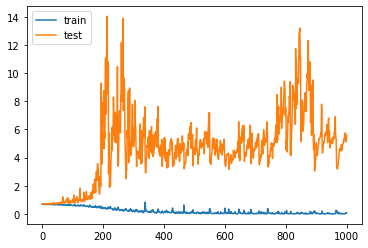

In [33]:
#plot loss graph

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

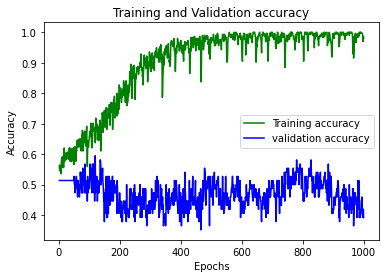

In [34]:
#plot training and validation accuracy

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,epochs + 1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
#predict values for test data
if(n_lag > 0):
    test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
else:
    test_X = test_X.reshape((test_X.shape[0], 1, n_features-1))

pred = model.predict(test_X)

if(n_lag > 0):
    test_X = test_X.reshape((test_X.shape[0], n_lag* n_features,))
else:
    test_X = test_X.reshape((test_X.shape[0], n_features-1,))

In [36]:
#change back from categorical
pred = np.argmax(pred, axis=1)

In [37]:
# calculate RMSE
mse = (mean_squared_error(test_y, pred))
print('Test MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(test_y, pred))
print('Test RMSE: %.3f' % rmse)

Test MSE: 0.333
Test RMSE: 0.577


In [38]:
#calculate accuracy
prices = pd.DataFrame()
prices["Actual"] = test_y
prices["Predicted"] = pred

prices["Correct"] = (prices["Actual"] - prices["Predicted"]) == 0
incorrect = prices.loc[prices['Correct'] == False]
incorrect_len = len(incorrect)
prices_len = len(prices)

print("Accuracy = ",((prices_len-incorrect_len)/prices_len))

Accuracy =  0.6666666666666666


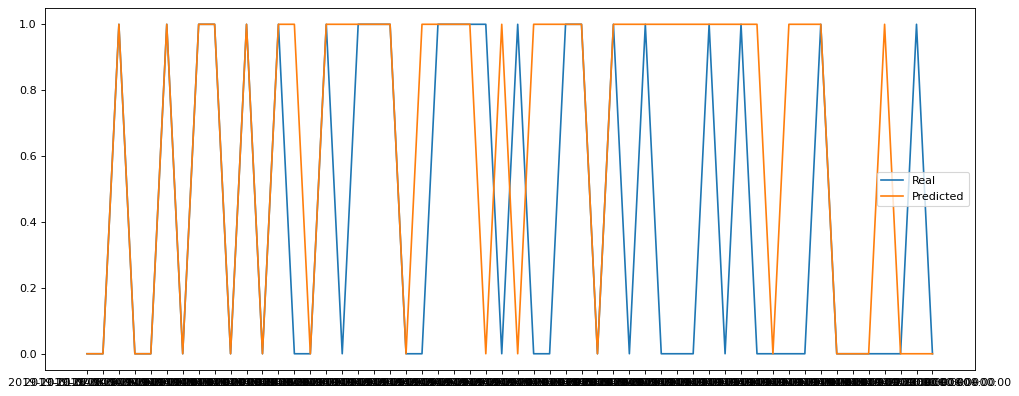

In [39]:
#plot price trends
times = pd.Series(df.index)
times = times[n_lag:]
times = times[train_size:]
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(times[:100], test_y[:100], label='Real')
plt.plot(times[:100], pred[:100], label='Predicted')
plt.legend()
plt.show()